# Анализ тарифов компании «Мегалайн»

Компания «Мегалайн», федерального оператор сотовой связи, предлагает клиентам два тарифных плана: «Смарт» и «Ультра».

Для корректировки рекламного бюджета, коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Цель данного исследования** — определить наиболее выгодный тариф Компании.

**Ход данного исследования**

Нам предстоит сделать предварительный анализ тарифов на небольшой
выборке клиентов.
В нашем распоряжении данные о 500 пользователях «Мегалайна» за 2018 год. Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Исследование пройдет в пять этапов:**
1. Верхнеуровневый анализ данных и объединение их в общие датасеты;
2. Предварительная обработка данных;
3. Исследовательский анализ данных;
4. Формулировка и проверка статистических гипотез;
5. Общий вывод.

**Описание данных**

- Таблица **`users (информация о пользователях)`**:
     1. `user_id` — уникальный идентификатор пользователя
     2. `first_name` — имя пользователя
     3. `last_name` — фамилия пользователя
     4. `age` — возраст пользователя (годы)
     5. `reg_date` — дата подключения тарифа (день, месяц, год)
     6. `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
     7. `city` — город проживания пользователя
     8. `tariff` — название тарифного плана


- Таблица **`calls (информация о звонках)`**:
     1. `id` — уникальный номер звонка
     2. `call_date` — дата звонка
     3. `duration` — длительность звонка в минутах
     4. `user_id` — идентификатор пользователя, сделавшего звонок


- Таблица **`messages (информация о сообщениях)`**:
     1. `id` — уникальный номер сообщения
     2. `message_date` — дата сообщения
     3. `user_id` — идентификатор пользователя, отправившего сообщение


- Таблица **`internet (информация об интернет-сессиях)`**:
     1. `id` — уникальный номер сессии
     2. `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
     3. `session_date` — дата интернет-сессии
     4. `user_id` — идентификатор пользователя


- Таблица **`tariffs (информация о тарифах)`**:
     1. `tariff_name` — название тарифа
     2. `rub_monthly_fee` — ежемесячная абонентская плата в рублях
     3. `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
     4. `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
     5. `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
     6. `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
     7. `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
     8. `rub_per_gb` — стоимость дополнительного гигабайта интернеттрафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# ____________________________________________________ Импорт библиотек
# Работа с данными
import pandas as pd
import numpy as np
from scipy import stats as st
import re

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка jupyter
import warnings
import os

# ____________________________________________________ Глобальные настройки
# Настройки для игнорирования предупреждений jupyter
warnings.filterwarnings('ignore')

# Настройки для отображения таблиц
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 100)
pd.options.display.max_colwidth = 75

b_start = '\033[1m' # начало жирного шрифта
b_end = '\033[0m' # конец жирного шрифта

# Настройка общей визуальной темы для графиков
sns.set_theme(style="whitegrid")

# Переменные
i = 0

# Загрузка данных, верхнеуровневый анализ и объединение данных в общие датасеты

Так как мы имеем дело с несколькими файлами данных, имеет смысл привести файлы к общему или общим датафреймам.

Чтобы сделать, это последовательно выполним следующие шаги:
1. Загрузим данные;
2. Проведем верхнеуровневый аналих данных;
3. Проведем необходиму обработку данных для их объединения;
4. Совместим данные в общие датафреймы.

### Используемые функции

In [3]:
def create_scan(df, asc=False):
    
    '''
    Функция представляет собой более удобный аналог метода pandas dataframe.info()
    
    Функция принимает на вход датасет с данными и признак сортировки данных ('asc')
    и возвращает количество дубликатов датасета и таблицу с информацией о всех полях исходного датасета.
    
        'values_num' - количество заполненных строк,
        'nan_values_num': количество пропусков
        'nan_values_percent': % пропусков
        'unique_values_num': количество уникальных значеий
        'unique_values': примеры уникальных значений
        'dtype': тип данных поля
    '''

    unique_values = []

    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique()) # asc

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nan_values_num': df.isna().sum(),
            'nan_values_percent': df.isna().sum() / (df.isna().sum() + df.notna().sum()) * 100,
            'unique_values_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )
    
    print('Дубликатов в таблице:', df.duplicated().sum())
    return table_scan

## Загрузка данных

Присвоим файлы с данными переменным и создадим список с названиями переменных

In [4]:
# ______________________________________________ calls.csv
calls_pth1 = 'calls.csv'
calls_pth2 = '/datasets/calls.csv'

if os.path.exists(calls_pth1):
    calls = pd.read_csv(calls_pth1)
elif os.path.exists(calls_pth2):
    calls = pd.read_csv(calls_pth2)
else:
    print('Ошибка!')
    
    
# ______________________________________________ internet.csv    
internet_pth1 = 'internet.csv'
internet_pth2 = '/datasets/internet.csv'

if os.path.exists(internet_pth1):
    internet = pd.read_csv(internet_pth1)
elif os.path.exists(internet_pth2):
    internet = pd.read_csv(internet_pth2)
else:
    print('Ошибка!')
    

# ______________________________________________ messages.csv    
messages_pth1 = 'messages.csv'
messages_pth2 = '/datasets/messages.csv'

if os.path.exists(messages_pth1):
    messages = pd.read_csv(messages_pth1)
elif os.path.exists(messages_pth2):
    messages = pd.read_csv(messages_pth2)
else:
    print('Ошибка!')
    

# ______________________________________________ users.csv    
users_pth1 = 'users.csv'
users_pth2 = '/datasets/users.csv'

if os.path.exists(users_pth1):
    users = pd.read_csv(users_pth1)
elif os.path.exists(users_pth2):
    users = pd.read_csv(users_pth2)
else:
    print('Ошибка!')
    

# ______________________________________________ tariffs.csv    
tariffs_pth1 = 'tariffs.csv'
tariffs_pth2 = '/datasets/tariffs.csv'

if os.path.exists(tariffs_pth1):
    tariffs = pd.read_csv(tariffs_pth1)
elif os.path.exists(tariffs_pth2):
    tariffs = pd.read_csv(tariffs_pth2)
else:
    print('Ошибка!')
    

# Список с названиями переменных 
names = ['calls', 'internet', 'messages', 'users', 'tariffs']

Ознакомимся с загруженными таблицами

In [5]:
count = 0

for i in [calls, internet, messages, users, tariffs]:
    
    print(names[count])
    count += 1
    
    display(i.head(2))
    print()

calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000



internet


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000



messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000



users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart



tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Верхнеуровневый анализ данных

In [6]:
count = 0

for i in [calls, internet, messages, users, tariffs]:
    print(f'------------------------------------------------- ТАБЛИЦА {names[count]} -------------------------------------------------')
    count += 1
    display(create_scan(i, asc=True))
    print()

------------------------------------------------- ТАБЛИЦА calls -------------------------------------------------
Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
id,202607,0,0.0,202607,"[1000_0, 1000_1, 1000_10, 1000_100, 1000_101, 1000_102, 1000_103, 1000_...",object
call_date,202607,0,0.0,365,"[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 2018-01-06...",object
duration,202607,0,0.0,2871,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, ...",float64
user_id,202607,0,0.0,492,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011...",int64



------------------------------------------------- ТАБЛИЦА internet -------------------------------------------------
Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
Unnamed: 0,149396,0,0.0,149396,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, ...",int64
id,149396,0,0.0,149396,"[1000_0, 1000_1, 1000_10, 1000_100, 1000_101, 1000_102, 1000_103, 1000_...",object
mb_used,149396,0,0.0,70003,"[0.0, 0.03, 0.04, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.16, 0.17, 0.18, ...",float64
session_date,149396,0,0.0,365,"[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 2018-01-06...",object
user_id,149396,0,0.0,497,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011...",int64



------------------------------------------------- ТАБЛИЦА messages -------------------------------------------------
Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
id,123036,0,0.0,123036,"[1000_0, 1000_1, 1000_10, 1000_100, 1000_101, 1000_102, 1000_103, 1000_...",object
message_date,123036,0,0.0,364,"[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 2018-01-06, 2018-01-07...",object
user_id,123036,0,0.0,426,"[1000, 1002, 1003, 1004, 1005, 1007, 1008, 1009, 1011, 1012, 1013, 1014...",int64



------------------------------------------------- ТАБЛИЦА users -------------------------------------------------
Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
user_id,500,0,0.0,500,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011...",int64
age,500,0,0.0,58,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35...",int64
churn_date,38,462,92.4,33,"[2018-08-17, 2018-08-31, 2018-09-02, 2018-09-26, 2018-09-27, 2018-10-03...",object
city,500,0,0.0,76,"[Архангельск, Астрахань, Балашиха, Барнаул, Белгород, Брянск, Владивост...",object
first_name,500,0,0.0,246,"[Авксентий, Агата, Агафья, Агнесса, Адам, Аким, Аксён, Алан, Алевтина, ...",object
last_name,500,0,0.0,419,"[Ёлчина, Ёркин, Ёркина, Ёрохов, Ёрохова, Абаимов, Абакумов, Абакшина, А...",object
reg_date,500,0,0.0,270,"[2018-01-01, 2018-01-02, 2018-01-04, 2018-01-05, 2018-01-06, 2018-01-08...",object
tariff,500,0,0.0,2,"[smart, ultra]",object



------------------------------------------------- ТАБЛИЦА tariffs -------------------------------------------------
Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
messages_included,2,0,0.0,2,"[50, 1000]",int64
mb_per_month_included,2,0,0.0,2,"[15360, 30720]",int64
minutes_included,2,0,0.0,2,"[500, 3000]",int64
rub_monthly_fee,2,0,0.0,2,"[550, 1950]",int64
rub_per_gb,2,0,0.0,2,"[150, 200]",int64
rub_per_message,2,0,0.0,2,"[1, 3]",int64
rub_per_minute,2,0,0.0,2,"[1, 3]",int64
tariff_name,2,0,0.0,2,"[smart, ultra]",object


------------------ calls_duration


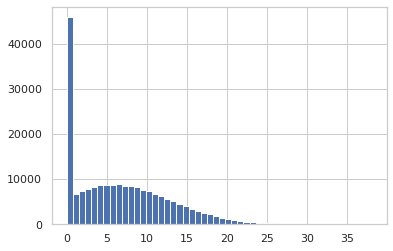

------------------ mb_used


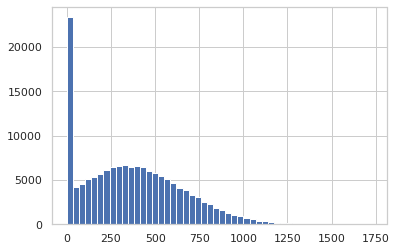

In [7]:
calls['duration'].hist(bins=50)
print('------------------ calls_duration')
plt.show()

internet['mb_used'].hist(bins=50)
print('------------------ mb_used')
plt.show()

В данных очень часто присутствует значение 0. Учтем это при дальнейшей работе.

## Обработка названий полей

Приведем все названия к единому стилю и добавим к названиям полей названия их таблиц для будущих слияний

In [8]:
calls = calls.rename(
    columns={
        'id': 'calls_id',
        'duration':'call_duration',
    }
)

internet = internet.drop(columns='Unnamed: 0').rename(
    columns={
        'id': 'internet_id', 
        'mb_used': 'internet_mb_used', 
        'session_date': 'internet_session_date',
    }
)

messages = messages.rename(
    columns={
        'id': 'messages_id',
    }
)

users = users.rename(
    columns={
        'age': 'users_age',
        'churn_date': 'users_churn_date',
        'city': 'users_city',
        'first_name': 'users_first_name',
        'last_name': 'users_last_name',
        'reg_date': 'users_reg_date',
        'tariff': 'tariff_name'
    }
)

## Объединения датафреймов

Для проведения дальнейшего анализа, необходимо объединить датафреймы таким образом, чтобы прослеживалась информация о тарифе каждого клиента.

Для этого стоит объединить таблицу с информацией о клиентах `users` с информацией о тарифах `tariffs` по полю `tariff_name`, а после совместить полученную таблицу с данными об использовании возможностей тарифов.

Так как поле `users` будет во всех датафреймах, сразу обработаем в нем поле `users_churn_date` и вычленим из него поле `users_churn_month` с информацией о месяце

In [9]:
users['users_churn_date'] = pd.to_datetime(users['users_churn_date'], format='%Y-%m-%d')
users['users_churn_month'] = users['users_churn_date'].dt.month

Далее создадим три датафрейма:
- `calls_data`
- `internet_data`
- `messages_data`

In [10]:
users_tariffs = users.merge(tariffs, on='tariff_name', how='left')

calls_data = calls.merge(users_tariffs, on='user_id', how='left')
internet_data = internet.merge(users_tariffs, on='user_id', how='left')
messages_data = messages.merge(users_tariffs, on='user_id', how='left')

# Предобработка данных

Чтобы подготовить данные к анализу необходимо предобрабоать их.

Для этого выполним следующие действия:
1. Для каждого датасета:
    - Приведем данные к нужным типам;
    - Определим и исправим ошибки в данных, если они есть.


2. Для каждого пользователя рассчитаем:
    - Количество сделанных звонков и израсходованных минут разговора по месяцам;
    - Количество отправленных сообщений по месяцам;
    - Объем израсходованного интернет-трафика по месяцам;
    - Помесячную выручку с каждого пользователя (вычтим бесплатный лимит из суммарного количества звонков, сообщений и интернет трафика; остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану).
    
3. Проверим обработанный датасет.

### Используемые функции

In [11]:
def get_call_revenue(df):
    
    rev = pd.Series(df['rub_per_minute'].fillna(0) * (df['call_duration'].fillna(0) - df['minutes_included']))
    
    for i in range(len(rev)):
        if rev[i] < 0:
            rev[i] = 0
    
    return rev

def get_messages_revenue(df):
    
    rev = pd.Series(df['rub_per_message'].fillna(0) * (df['messages_amount'].fillna(0) - df['messages_included']))
        
    for i in range(len(rev)):
        if rev[i] < 0:
            rev[i] = 0
    
    return rev

def get_internet_revenue(df):
    
    rev = pd.Series(df['rub_per_gb'].fillna(0) * (df['internet_gb_used'].fillna(0) - (df['mb_per_month_included'] / 1024)))
        
    for i in range(len(rev)):
        if rev[i] < 0:
            rev[i] = 0
    
    return rev

def get_total_revenue(df):
    
    return df['call_revenue'] + df['messages_revenue'] + df['internet_revenue'] + df['rub_monthly_fee']

## Обработка датасетов

### `calls_data`

Приведем данные к нужным типам:
1. `call_date` к datetime
2. `call_duration` к int и округляим до целых

In [12]:
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
calls_data['call_month'] = calls_data['call_date'].dt.month

calls_data['call_duration'] = np.ceil(calls_data['call_duration'])

### `messages_data`

Приведем `message_date` к datetime

In [13]:
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
messages_data['message_month'] = messages_data['message_date'].dt.month

### `internet_data`

Приведем `internet_session_date` к datetime

In [14]:
internet_data['internet_session_date'] = pd.to_datetime(internet_data['internet_session_date'], format='%Y-%m-%d')
internet_data['internet_month'] = internet_data['internet_session_date'].dt.month

## Расчет метрик для каждого пользователя

Сведем данные в таблицу `month_info` со следующими полями:
- `calls_amount` - количество сделанных звонков; 
- `call_duration` количество израсходованных минут разговора по месяцам;
- `messages_amount` количество отправленных сообщений по месяцам;
- `internet_gb_used` объем израсходованного интернет-трафика по месяцам.

Учтем, что количество интернет трафика расчитывается в гигабайтах.

Для этого сведенное поле `internet_gb_used` будет необходимо разделить на 1024 и округлить в большую сторону.

### Сведение данных из датафреймов к одному датасету `data`

In [15]:
# Создаем сводную таблицу из датафреймов с инфоромацией о суммах и количествах метрик
calls_num = calls_data.pivot_table(
    index=['user_id', 'call_month'], values='calls_id', aggfunc='count'
).reset_index().rename(
    columns={
        'call_month': 'month',
        'calls_id': 'calls_amount',
    }
)

calls_dur = calls_data.pivot_table(index=['user_id', 'call_month'], values='call_duration', aggfunc='sum').reset_index().rename(columns={'call_month': 'month'})

messages_num = messages_data.pivot_table(
    index=['user_id', 'message_month'], values='messages_id', aggfunc='count'
).reset_index().rename(
    columns={
        'message_month': 'month',
        'messages_id': 'messages_amount'
    }
)

internet_used = internet_data.pivot_table(
    index=['user_id', 'internet_month'], values='internet_mb_used', aggfunc='sum'
).reset_index().rename(
    columns={
        'internet_month': 'month',
        'internet_mb_used': 'internet_gb_used',
    }
)

# Обрабатываем сводные таблицы и приводим их к форме датафрейма
month_info = calls_num.merge(
    calls_dur, on=['user_id', 'month'], how='outer'
).merge(
    messages_num, on=['user_id', 'month'], how='outer'
).merge(
    internet_used, on=['user_id', 'month'], how='outer'
)

month_info['internet_gb_used'] = np.ceil(month_info['internet_gb_used'] / 1024) # Приводим мегабайты к гигабайтам и округляем в большую сторону

data = month_info.merge(users_tariffs, on='user_id', how='left')

display(data.sample(3))


# Проверяем вхожение всех `user_id` в датасет
lost_ids = []

for i in users['user_id']:
    if i not in data['user_id'].unique():
        lost_ids.append(i)
        
lost_ids

,user_id,month,calls_amount,call_duration,messages_amount,internet_gb_used,users_age,users_churn_date,users_city,users_first_name,users_last_name,users_reg_date,tariff_name,users_churn_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
684,1110,7,65.0,520.0,37.0,19.0,26,NaT,Петрозаводск,Матвей,Александрович,2018-05-06,smart,NaN,50,15360,500,550,200,3,3
3069,1481,4,42.0,361.0,21.0,20.0,70,NaT,Москва,Клавдия,Чижова,2018-02-26,smart,NaN,50,15360,500,550,200,3,3
263,1043,9,44.0,295.0,9.0,27.0,69,NaT,Ставрополь,Марианна,Родионова,2018-07-08,smart,NaN,50,15360,500,550,200,3,3


[1128, 1371]

Проверим наличие данных `user_id` в датафреймах с услугами

In [16]:
display(
    calls.query('user_id in @lost_ids'),
    messages.query('user_id in @lost_ids'),
    internet.query('user_id in @lost_ids')
)

,calls_id,call_date,call_duration,user_id


,messages_id,message_date,user_id


,internet_id,internet_mb_used,internet_session_date,user_id


Оба непопавших в датасет `user_id` отсутствуют в исходных данных, следовательно можно сделать вывод, об удачном объединении таблиц.

### Расчет помесячной выручки для каждого клиента

Для рассчетов выручки необходимо проверить поля на наличие пропусков

In [17]:
print(
    len(
        data[
        (data['messages_amount'].isna() == True) |
        (data['calls_amount'].isna() == True) |
        (data['call_duration'].isna() == True) |
        (data['internet_gb_used'].isna() == True)
        ]
    )
)

data[
    (data['messages_amount'].isna() == True) |
    (data['calls_amount'].isna() == True) |
    (data['call_duration'].isna() == True) |
    (data['internet_gb_used'].isna() == True)
].sample(3)

547


,user_id,month,calls_amount,call_duration,messages_amount,internet_gb_used,users_age,users_churn_date,users_city,users_first_name,users_last_name,users_reg_date,tariff_name,users_churn_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
2897,1456,10,127.0,889.0,NaN,22.0,40,NaT,Санкт-Петербург,Мануэла,Андропова,2018-08-25,smart,NaN,50,15360,500,550,200,3,3
3200,1328,11,NaN,NaN,8.0,35.0,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,NaN,1000,30720,3000,1950,150,1,1
1808,1290,7,73.0,437.0,NaN,19.0,68,NaT,Нижний Новгород,Арсений,Безруков,2018-05-11,smart,NaN,50,15360,500,550,200,3,3


Расчитаем выручки по следующей логике:

1. Выручка от звонков:

   `call_revenue` = rub_per_minute * (call_duration - minutes_included) Если меньше 0, то выручка = 0

2. Выручка от SMS:

    `messages_revenue` = rub_per_message * (messages_amount - messages_included) Если меньше 0, то выручка = 0


3. Выручка от SMS:

    `internet_revenue` = rub_per_gb * (internet_gb_used - mb_per_month_included) Если меньше 0, то выручка = 0
 
 
4. Выручка от SMS:

    `total_revenue` = call_revenue + messages_revenue + internet_revenue + rub_monthly_fee

In [18]:
data['call_revenue'] = get_call_revenue(data)
data['messages_revenue'] = get_messages_revenue(data)
data['internet_revenue'] = get_internet_revenue(data)
data['total_revenue'] = get_total_revenue(data)

data[['rub_monthly_fee', 'call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue']].sample(3)

,rub_monthly_fee,call_revenue,messages_revenue,internet_revenue,total_revenue
1170,1950,0.0,0.0,1800.0,3750.0
3113,550,0.0,159.0,400.0,1109.0
797,1950,0.0,0.0,0.0,1950.0


## Проверка обработанного датасета

In [19]:
create_scan(data)

Дубликатов в таблице: 0


,values_num,nan_values_num,nan_values_percent,unique_values_num,unique_values,dtype
user_id,3214,0,0.000000,498,"[1499, 1498, 1497, 1496, 1495, 1494, 1493, 1492, 1491, 1490, 1489, 1488...",int64
month,3214,0,0.000000,12,"[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]",int64
calls_amount,3174,40,1.244555,183,"[244.0, 203.0, 198.0, 196.0, 189.0, 188.0, 185.0, 184.0, 183.0, 182.0, ...",float64
call_duration,3174,40,1.244555,925,"[1673.0, 1609.0, 1435.0, 1410.0, 1401.0, 1345.0, 1334.0, 1322.0, 1321.0...",float64
messages_amount,2717,497,15.463597,179,"[224.0, 223.0, 211.0, 201.0, 197.0, 191.0, 190.0, 188.0, 185.0, 183.0, ...",float64
internet_gb_used,3203,11,0.342253,48,"[49.0, 48.0, 45.0, 44.0, 43.0, 42.0, 41.0, 40.0, 39.0, 38.0, 37.0, 36.0...",float64
users_age,3214,0,0.000000,58,"[75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58...",int64
users_churn_date,187,3027,94.181705,31,"[2018-12-26T00:00:00.000000000, 2018-12-25T00:00:00.000000000, 2018-12-...",datetime64[ns]
users_city,3214,0,0.000000,76,"[Ярославль, Якутск, Чита, Череповец, Челябинск, Чебоксары, Химки, Хабар...",object
users_first_name,3214,0,0.000000,246,"[Яна, Яков, Юрий, Юна, Юлия, Юлий, Юзефа, Эсмеральда, Эмилия, Эльмира, ...",object


Датасет готов к проведению исследовательского анализа

# Исследовательский анализ данных

Проведем анализ в пять этапов:
1. Проанализируем информацию о тарифах, разбив данные по Клиентам;
2. Рассмотрим метрики для тарифов;
3. Рассмотрим выручки для тарифов;
4. Определим динамику выручки в 2018 году;
5. Расчитаем корреляции параметров.

### Используемые функции

In [21]:
smart_data = data.query('tariff_name == "smart"')
ultra_data = data.query('tariff_name == "ultra"')

# ------------------------------------------------------------------------------------------------------------------------ Определение пола Клиента на основе его имени
def check_gender(row):
    
    if type(re.fullmatch('.*я$', row)) == re.Match:
        return 'Женский'
    elif type(re.fullmatch('.*я$', row)) == re.Match:
        return 'Женский'
    elif type(re.fullmatch('.*я$', row)) == re.Match:
        return 'Женский'
    else:
        return 'Мужской'

# ------------------------------------------------------------------------------------------------------------------------ Сводная таблица с медианами или средними
def create_pivot(df=data, func='median', val='total_revenue'):
    
    display(
        df.pivot_table(
            index=['month', 'tariff_name'],
            values=val,
            aggfunc=func
        ).astype('int').T
    )

# ------------------------------------------------------------------------------------------------------------------------ Боксплоты и гистограммы
def get_hist_plots_2dfs(df1, df2, i=i, bins_=50, size=(21, 5)):

    sns.set_theme(style="whitegrid")

    f, (ax_box, ax_hist) = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=size)
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

    sns.boxplot(df1[i], ax=ax_box[0]).set_title(f'Тариф "Smart". Распределение `{i}`', y=1.5, fontsize = 14)
    sns.histplot(df1[i], bins=bins_, kde=True, ax=ax_hist[0])

    sns.boxplot(df2[i], ax=ax_box[1]).set_title(f'Тариф "Ultra". Распределение `{i}`', y=1.5, fontsize = 14)
    sns.histplot(df2[i], bins=bins_, kde=True, ax=ax_hist[1])

    ax_box[0].set(xlabel='')
    ax_box[1].set(xlabel='')

    plt.show()    

# ------------------------------------------------------------------------------------------------------------------------ Таблица со статистикой
def get_stats_table(df1=smart_data, df2=ultra_data, i=i):

    desc = round(
        (
            df1[i]
            .describe()
            .reset_index()
                .merge(
                    df2[i].describe().reset_index(),
                    on='index'
                ).merge(
                    data[i].describe().reset_index(),
                    on='index'
                )
        ).rename(
            columns={
                'index': 'STATS',
                f'{i}_x': f'{i}_SMART',
                f'{i}_y': f'{i}_ULTRA',
                f'{i}': f'{i}_ALL',
            }
        ), 
        2
    )[
        [
            'STATS',
            f'{i}_ALL',
            f'{i}_SMART',
            f'{i}_ULTRA',
        ]
    ]
    
    display(desc)
    
    desc = desc.query('STATS != "count"')
    
    f, ax = plt.subplots(1, 3, figsize=(21, 4), sharey=True)
    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    
    sns.barplot(x=desc['STATS'], y=desc[f'{i}_ALL'], ax=ax[0]).set_xlabel('ALL')
    sns.barplot(x=desc['STATS'], y=desc[f'{i}_SMART'], ax=ax[1]).set_xlabel('SMART')
    sns.barplot(x=desc['STATS'], y=desc[f'{i}_ULTRA'], ax=ax[2]).set_xlabel('ULTRA')
    
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    
    #ax[0].set_yscale("log")
    #ax[1].set_yscale("log")
    
    #plt.subplots_adjust(wspace=.35, hspace=0)
    
    plt.show()

## Анализ тарифов по Клиентам

### Распределение тарифов в зависимости от гендера Клиента

In [22]:
data['gender'] = data['users_first_name'].apply(check_gender)

tariff_name,smart,ultra,amount,ultra_percent
gender,,,,
Женский,218,131,349,0.375358
Мужской,2011,854,2865,0.298080


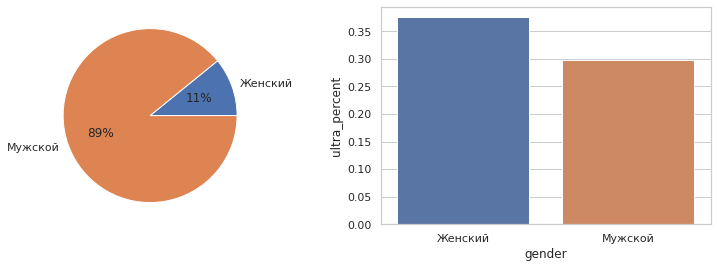

In [23]:
gender_tariffs = pd.crosstab(
    data['gender'],
    data['tariff_name']
).assign(
    amount=lambda x: x['smart'] + x['ultra']
).assign(
    ultra_percent=lambda x: x['ultra'] / (x['smart'] + x['ultra'])
)

display(gender_tariffs)

f, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].pie(gender_tariffs['amount'], labels = gender_tariffs.index, autopct='%.0f%%', colors=sns.color_palette('deep')[0:2])
sns.barplot(x=gender_tariffs.index, y=gender_tariffs['ultra_percent'], ax=ax[1])
plt.show()

Можно сделать следующие выводы:
- Клиентов-женщин меньше почти в 10 раз, что может говорить о недостаточной проработке данного сегмента рынка;
- Клиенты-женщины на 8% чаще выбирают тариф "Ультра", однако стоит учитывать относительно небольшую выборку всего в 349 человек.

### Средняя выручка в зависимости от гендера Клиента

,call_revenue,internet_revenue,messages_revenue,total_revenue
gender,,,,
Женский,56.011461,397.851003,3.954155,1533.318052
Мужской,90.285864,457.905759,13.055497,1528.559511


<AxesSubplot:xlabel='gender'>

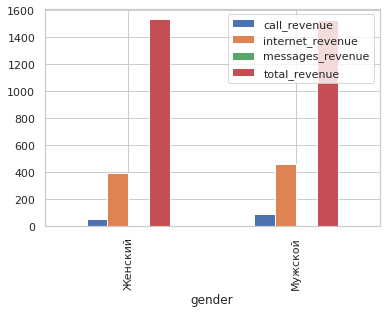

In [24]:
gender_revenue = data.pivot_table(index='gender', values=['call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue'], aggfunc='mean')

display(gender_revenue)

gender_revenue.plot(kind='bar')

Из проведенного анализа видно:
- Гендер не влияет на общую выручку: у Клиентов-мужчин и женщин она практически одинакова;
- Гендер влияет на выручку от звонков, интернета и SMS - Клиенты-мужчины тратят на эти категории значительно больше.

### Доля тарифов в различных городах

users_city,Нижневартовск,Сургут,Брянск,Иваново,Курган,Нижний Тагил,Кемерово,Воронеж,Пенза,Тверь,Оренбург,Тольятти,Тула,Кострома,Барнаул,Мурманск,Стерлитамак,Краснодар,Калуга,Новосибирск,Нижний Новгород,Челябинск,Саранск,Ростов-на-Дону,Чебоксары,...,Киров,Севастополь,Казань,Магнитогорск,Ульяновск,Химки,Хабаровск,Чита,Якутск,Улан-Удэ,Архангельск,Тамбов,Ставрополь,Подольск,Петрозаводск,Орёл,Липецк,Курск,Калининград,Ижевск,Грозный,Волжский,Владикавказ,Белгород,Новороссийск
tariff_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
smart,0.0,0.0,0.0,0.0,1.000000,5.000000,1.0,8.000000,12.000000,5.000000,4.000000,9.000000,5.000000,9.000,7.000000,11.00,8.0,45.000000,13.000000,54.00000,31.000000,30.000000,13.000000,18.0,12.0,...,28.000000,10.000000,74.000000,33.000000,81.000000,5.0,19.0,18.0,17.0,48.0,12.0,23.0,37.0,12.0,35.0,25.0,7.0,14.0,17.0,16.0,12.0,7.0,7.0,15.0,26.0
ultra,6.0,6.0,28.0,2.0,18.000000,21.000000,4.0,31.000000,43.000000,12.000000,9.000000,19.000000,9.000000,15.000,11.000000,14.00,8.0,41.000000,11.000000,44.00000,23.000000,22.000000,9.000000,12.0,8.0,...,3.000000,1.000000,3.000000,1.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
smart_percent,0.0,0.0,0.0,0.0,0.052632,0.192308,0.2,0.205128,0.218182,0.294118,0.307692,0.321429,0.357143,0.375,0.388889,0.44,0.5,0.523256,0.541667,0.55102,0.574074,0.576923,0.590909,0.6,0.6,...,0.903226,0.909091,0.961039,0.970588,0.975904,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ultra_percent,1.0,1.0,1.0,1.0,0.947368,0.807692,0.8,0.794872,0.781818,0.705882,0.692308,0.678571,0.642857,0.625,0.611111,0.56,0.5,0.476744,0.458333,0.44898,0.425926,0.423077,0.409091,0.4,0.4,...,0.096774,0.090909,0.038961,0.029412,0.024096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


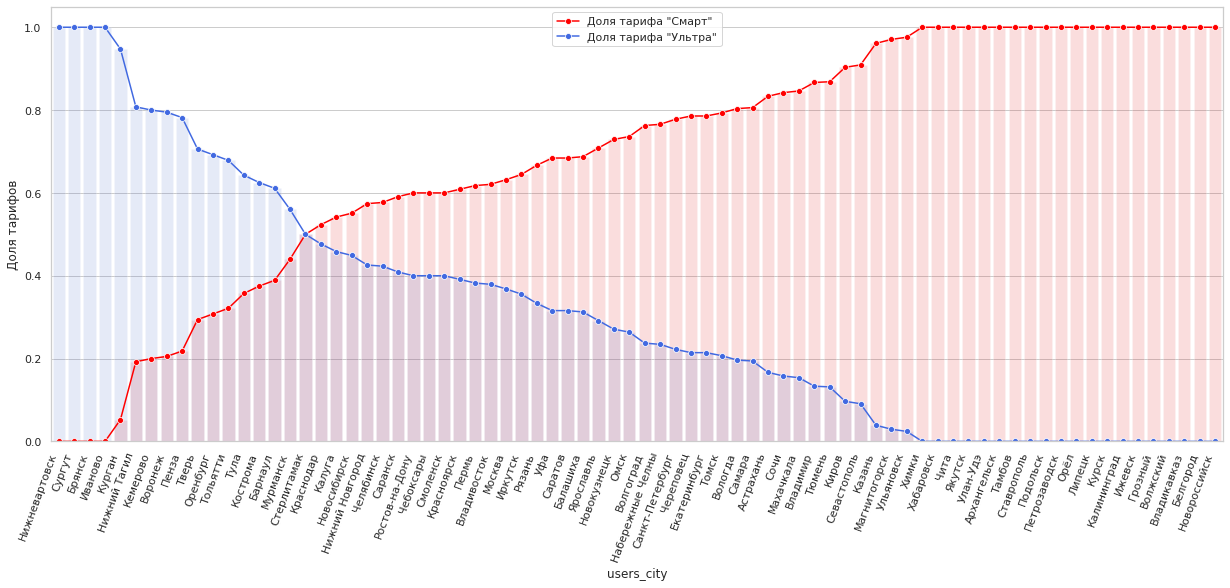

In [25]:
city_tariffs = pd.crosstab(
    data['users_city'],
    data['tariff_name']
).assign(
    smart_percent=lambda x: x['smart'] / (x['smart'] + x['ultra'])
).assign(
    ultra_percent=lambda x: x['ultra'] / (x['smart'] + x['ultra'])
).sort_values(by='ultra_percent', ascending=False)

display(city_tariffs.T)

#city_tariffs = city_tariffs.reset_index(drop=True)

plt.figure(figsize=(21, 8))
sns.lineplot(x=city_tariffs.index, y=city_tariffs['smart_percent'], marker='o', color='red')
sns.lineplot(x=city_tariffs.index, y=city_tariffs['ultra_percent'], marker='o', color='royalblue')
sns.barplot(x=city_tariffs.index, y=city_tariffs['smart_percent'], alpha=0.15, color='red')
sns.barplot(x=city_tariffs.index, y=city_tariffs['ultra_percent'], alpha=0.15, color='royalblue').set_ylabel('Доля тарифов')
plt.xticks(rotation=70, horizontalalignment='right')
legend=['Доля тарифа "Смарт"', 'Доля тарифа "Ультра"']
plt.legend(legend)
plt.show()

Можно скзать, что:
- Доля тарифов сильно не равномерна в разных регионах;
- Присутствуют регионы, в которых представлен только один тариф

### Средняя и медианная выручка в различных городах

,0,1,2,3,4,5,6,8,9,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
city,Воронеж,Саранск,Череповец,Оренбург,Брянск,Чебоксары,Мурманск,Сургут,Иваново,Нижневартовск,Нижний Новгород,Тольятти,Курган,Красноярск,Нижний Тагил,Кемерово,Тула,Пенза,Новосибирск,Ростов-на-Дону,Челябинск,Севастополь,Кострома,Вологда,Сочи,...,Екатеринбург,Волгоград,Липецк,Петрозаводск,Архангельск,Владикавказ,Ульяновск,Грозный,Иркутск,Казань,Ставрополь,Чита,Калининград,Тюмень,Смоленск,Томск,Новокузнецк,Орёл,Магнитогорск,Подольск,Волжский,Новороссийск,Белгород,Химки,Тамбов
mean_revenue,2296.230769,2176.954545,2116.928571,2059.153846,2030.357143,1995.7,1984.52,1950.0,1950.0,1950.0,1925.388889,1922.428571,1897.368421,1894.26087,1871.730769,1833.0,1800.857143,1784.254545,1781.040816,1751.466667,1718.134615,1717.181818,1676.166667,1631.607143,1630.394737,...,1389.261905,1388.491525,1342.285714,1336.085714,1296.583333,1283.571429,1282.963855,1273.166667,1261.2,1221.987013,1218.0,1204.888889,1169.764706,1138.052632,1135.933333,1132.586207,1086.520833,1064.72,1009.676471,963.833333,864.285714,827.269231,737.4,638.4,596.478261
median_revenue,2126.5,2013.5,1995.5,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,...,1156.0,1154.0,1150.0,1150.0,1122.0,1073.0,1032.5,993.0,977.0,950.0,950.0,950.0,933.0,922.0,885.5,710.5,653.5,631.0,610.0,601.0,601.0,550.0,550.0,550.0,550.0


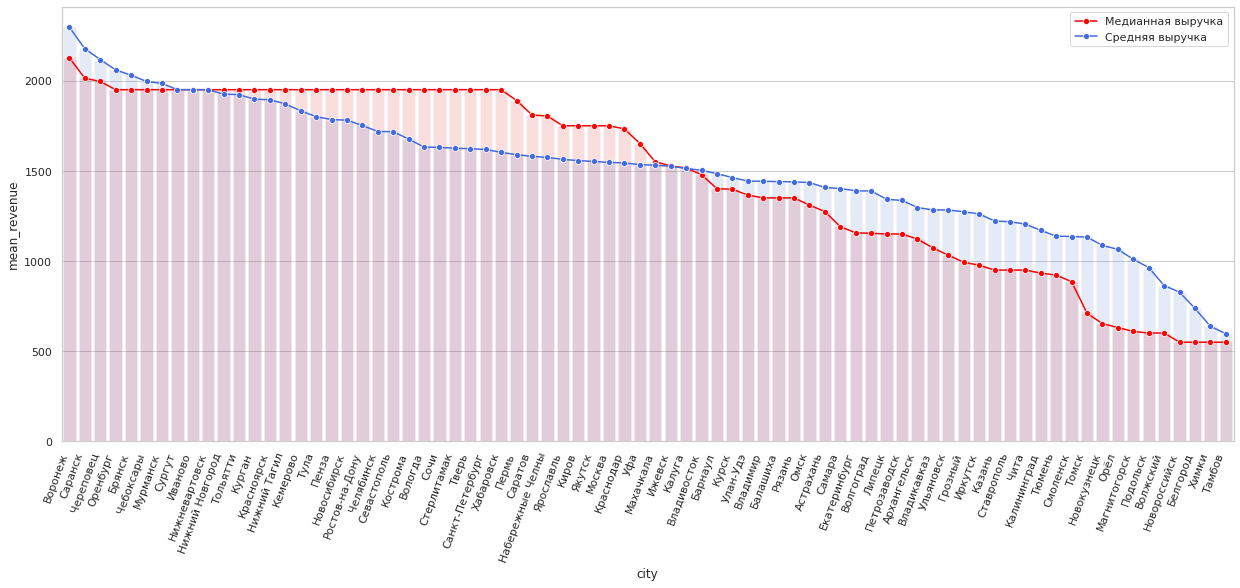

In [26]:
city_revenue_mean = data.pivot_table(index='users_city', values='total_revenue', aggfunc='mean').sort_values(by='total_revenue', ascending=False)#.head(20)
city_revenue_median = data.pivot_table(index='users_city', values='total_revenue', aggfunc='median').sort_values(by='total_revenue', ascending=False)#.head(20)

city_revenue_median_and_median = city_revenue_mean.merge(city_revenue_median, on=city_revenue_mean.index)

city_revenue_median_and_median = city_revenue_median_and_median.rename(columns={'key_0': 'city', 'total_revenue_x': 'mean_revenue', 'total_revenue_y': 'median_revenue'})
city_revenue_median_and_median = city_revenue_median_and_median.sort_values(by='mean_revenue', ascending=False)


display(city_revenue_median_and_median.T)


plt.figure(figsize=(21, 8))

sns.lineplot(x=city_revenue_median_and_median['city'], y=city_revenue_median_and_median['median_revenue'], marker='o', color='red').set_ylabel('Выручка')
sns.lineplot(x=city_revenue_median_and_median['city'], y=city_revenue_median_and_median['mean_revenue'], marker='o', color='royalblue')

sns.barplot(x=city_revenue_median_and_median['city'], y=city_revenue_median_and_median['median_revenue'], alpha=0.15, color='red')
sns.barplot(x=city_revenue_median_and_median['city'], y=city_revenue_median_and_median['mean_revenue'], alpha=0.15, color='royalblue')

plt.xticks(rotation=70, horizontalalignment='right')
legend=['Медианная выручка', 'Средняя выручка']
plt.legend(legend)
plt.show()

Из графика средней и медианной выручки видно, что
- показатели неравномерно распределяется по городам;
- Медианная выручка сильно искажается из-за непревышения Клиентами лимитов тарифа, в следствие чего, целесообразнее использовать показатель средней выручки при дальнейшем анализе.

## Анализ метрик для тарифов

### Распределения метрик

   -----------------------------------------------------------------------------------------------------------------------------------------
1. ----------------------------------------------------- Анализ параметра calls_amount -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра: 



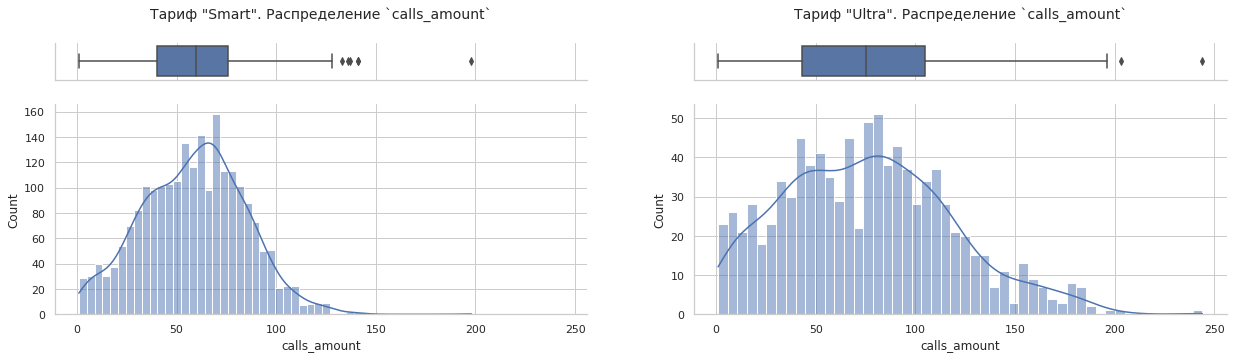



Описательные статистики параметра:

Дисперсия параметра: 1067.52


,STATS,calls_amount_ALL,calls_amount_SMART,calls_amount_ULTRA
0,count,3174.00,2223.00,951.00
1,mean,63.83,58.62,76.02
2,std,32.68,25.80,42.40
3,min,1.00,1.00,1.00
4,25%,41.00,40.00,43.00
5,50%,63.00,60.00,75.00
6,75%,83.00,76.00,105.00
7,max,244.00,198.00,244.00


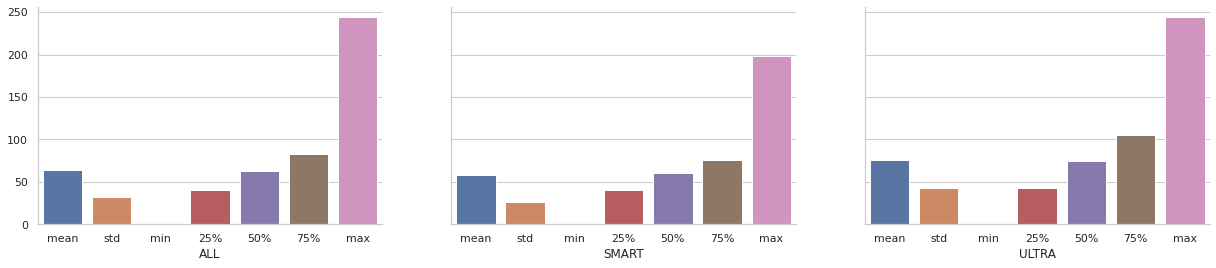




   -----------------------------------------------------------------------------------------------------------------------------------------
2. ----------------------------------------------------- Анализ параметра call_duration -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра: 



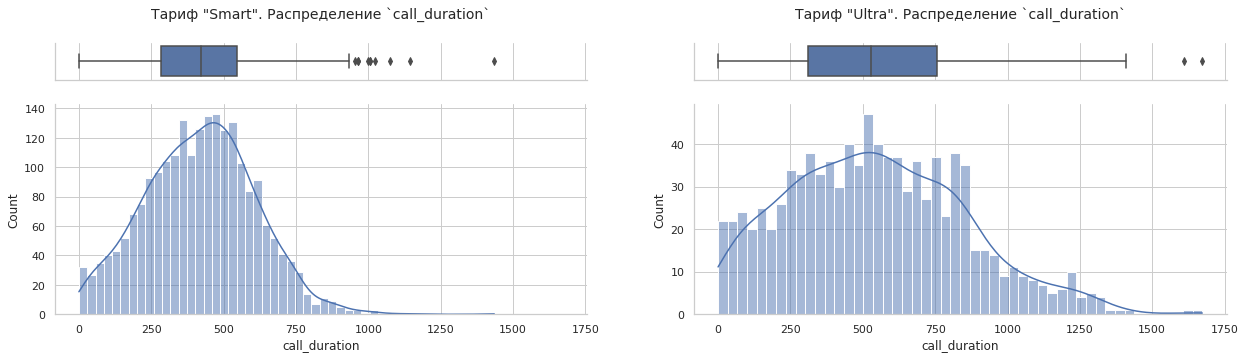



Описательные статистики параметра:

Дисперсия параметра: 56641.03


,STATS,call_duration_ALL,call_duration_SMART,call_duration_ULTRA
0,count,3174.00,2223.00,951.00
1,mean,456.93,419.06,545.45
2,std,238.03,189.33,306.93
3,min,0.00,0.00,0.00
4,25%,290.00,285.00,310.00
5,50%,447.00,423.00,528.00
6,75%,592.00,545.50,756.50
7,max,1673.00,1435.00,1673.00


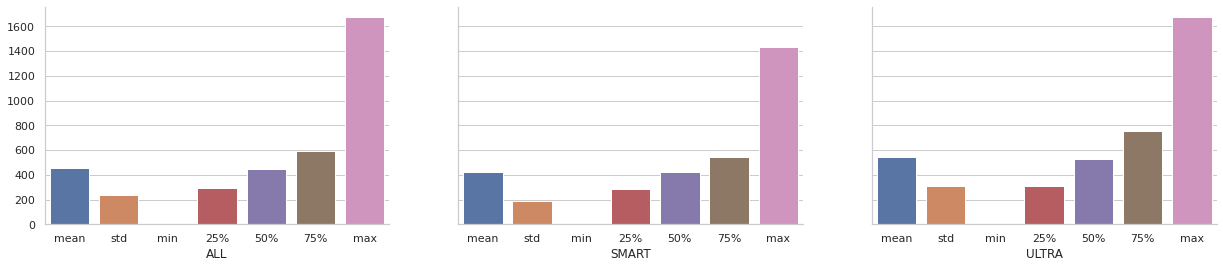




   -----------------------------------------------------------------------------------------------------------------------------------------
3. ----------------------------------------------------- Анализ параметра messages_amount -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра: 



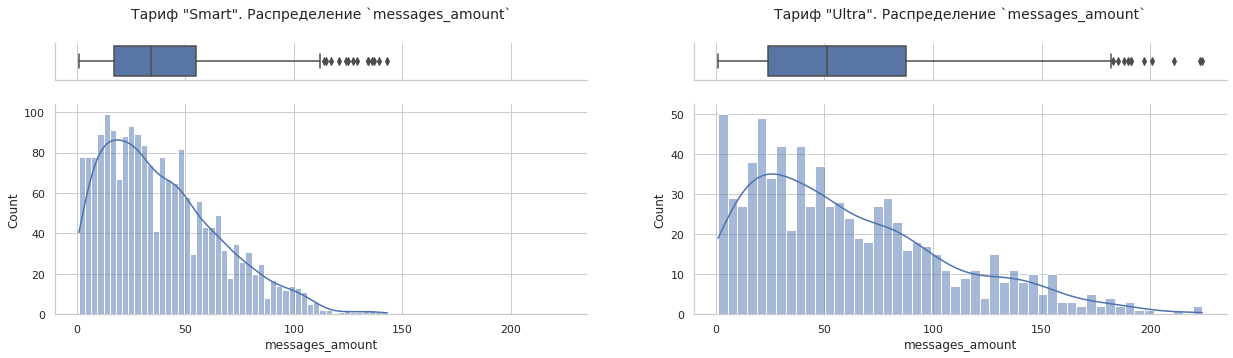



Описательные статистики параметра:

Дисперсия параметра: 1228.15


,STATS,messages_amount_ALL,messages_amount_SMART,messages_amount_ULTRA
0,count,2717.00,1922.00,795.00
1,mean,45.28,38.72,61.16
2,std,35.05,26.79,45.93
3,min,1.00,1.00,1.00
4,25%,19.00,17.00,24.00
5,50%,38.00,34.00,51.00
6,75%,63.00,55.00,87.50
7,max,224.00,143.00,224.00


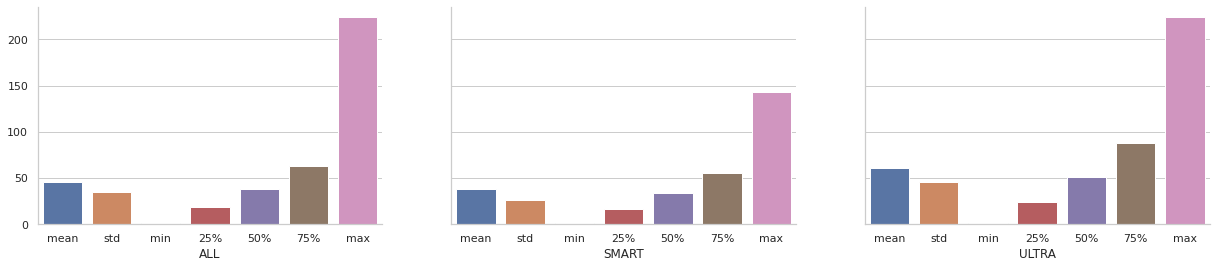




   -----------------------------------------------------------------------------------------------------------------------------------------
4. ----------------------------------------------------- Анализ параметра internet_gb_used -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра: 



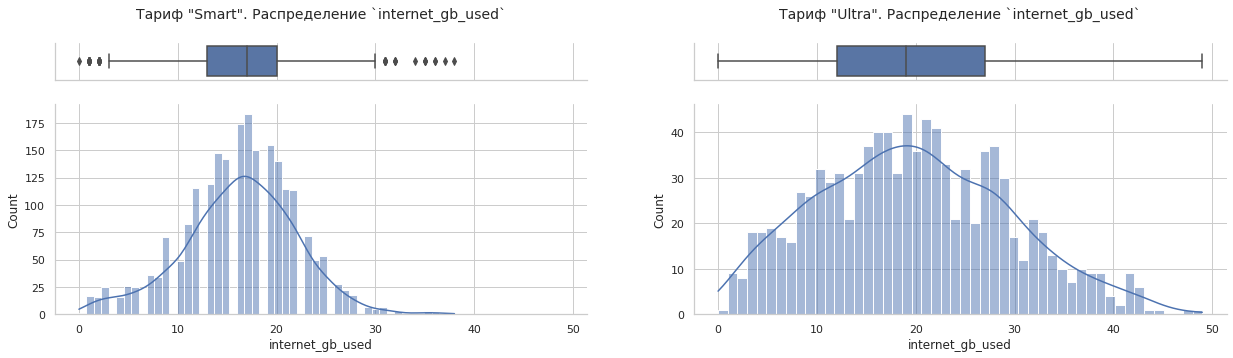



Описательные статистики параметра:

Дисперсия параметра: 53.91


,STATS,internet_gb_used_ALL,internet_gb_used_SMART,internet_gb_used_ULTRA
0,count,3203.00,2228.00,975.00
1,mean,17.36,16.34,19.69
2,std,7.34,5.74,9.70
3,min,0.00,0.00,0.00
4,25%,13.00,13.00,12.00
5,50%,17.00,17.00,19.00
6,75%,21.00,20.00,27.00
7,max,49.00,38.00,49.00


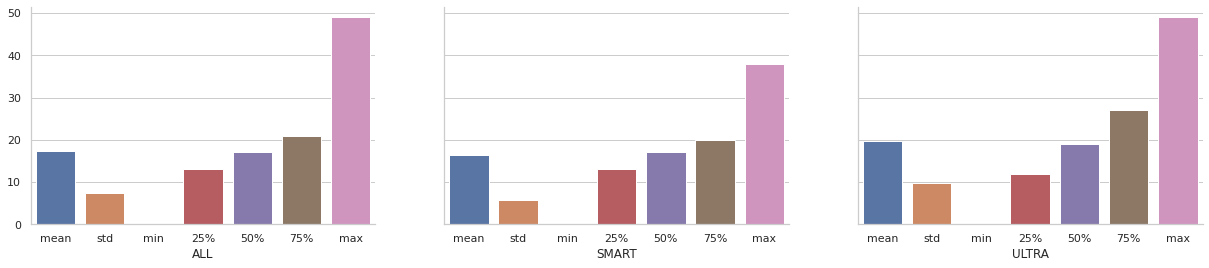

In [27]:
smart_data = data.query('tariff_name == "smart"')[['calls_amount', 'call_duration', 'messages_amount', 'internet_gb_used']]
ultra_data = data.query('tariff_name == "ultra"')[['calls_amount', 'call_duration', 'messages_amount', 'internet_gb_used']]

count = 0

for i in smart_data.columns:
    count += 1
    print(f'{b_start}   -----------------------------------------------------------------------------------------------------------------------------------------')
    print(f'{count}. ----------------------------------------------------- Анализ параметра {i} -----------------------------------------------------')
    print(f'   -----------------------------------------------------------------------------------------------------------------------------------------')
    print('\n')
    
    print(f'Графики распределения параметра: ')
    print()
    
    get_hist_plots_2dfs(df1=smart_data, df2=ultra_data, i=i)
    print('\n')
    
    print(f'{b_start}Описательные статистики параметра:')
    print()
    print('Дисперсия параметра:', round(np.var(data[i]), 2))
    get_stats_table(df1=smart_data, df2=ultra_data, i=i)
    print('\n'*2)

### Медианы и средние для метрик

In [28]:
print(f'{b_start}Медианы для всех параметров:')
create_pivot(df=data, func='median', val=['calls_amount', 'call_duration', 'messages_amount', 'internet_gb_used'])
print('\n')

print(f'{b_start}Cредние для всех параметров:')
create_pivot(df=data, func='mean', val=['calls_amount', 'call_duration', 'messages_amount', 'internet_gb_used'])

Медианы для всех параметров:


month               1           2           3           4           5         \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_duration      162   382   258   168   409   403   368   485   433   527   
calls_amount        20    51    38    25    59    57    52    63    59    76   
internet_gb_used     7    15    13    10    16    18    14    17    16    19   
messages_amount     16    50    22    35    29    27    32    34    37    34   

month               6           7           8           9           10        \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_duration      401   483   414   570   432   512   436   531   428   540   
calls_amount        59    69    58    79    62    74    61    77    61    76   
internet_gb_used    16    20    16    20    17    19    16    20    17    20   
messages_amount     33    39    35    51    33    47    34    56    35    61   

month               11          12        
tariff_name      smart ultra smart ultra  
call_duration      430   552   471   592  
calls_amount        60    80    65    84  
internet_gb_used    17    19    18    22  
messages_amount     34    58    38    61



Cредние для всех параметров:


month               1           2           3           4           5         \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_duration      203   428   298   297   390   489   367   475   387   534   
calls_amount        27    59    40    41    54    67    51    66    55    75   
internet_gb_used     8    13    11    13    15    17    13    16    15    19   
messages_amount     20    43    27    32    35    47    35    44    39    48   

month               6           7           8           9           10        \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_duration      398   497   408   564   423   530   430   558   427   581   
calls_amount        55    69    56    78    59    74    59    77    60    80   
internet_gb_used    15    19    15    20    16    19    16    19    16    20   
messages_amount     38    52    38    62    38    58    39    63    39    69   

month               11          12        
tariff_name      smart ultra smart ultra  
call_duration      436   562   479   614  
calls_amount        61    78    66    86  
internet_gb_used    17    19    18    21  
messages_amount     39    66    42    72

## Анализ выручки для тарифов

### Распределения выручки

   -----------------------------------------------------------------------------------------------------------------------------------------
1. ----------------------------------------------------- Анализ параметра call_revenue -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра без учета нулевых значений: 



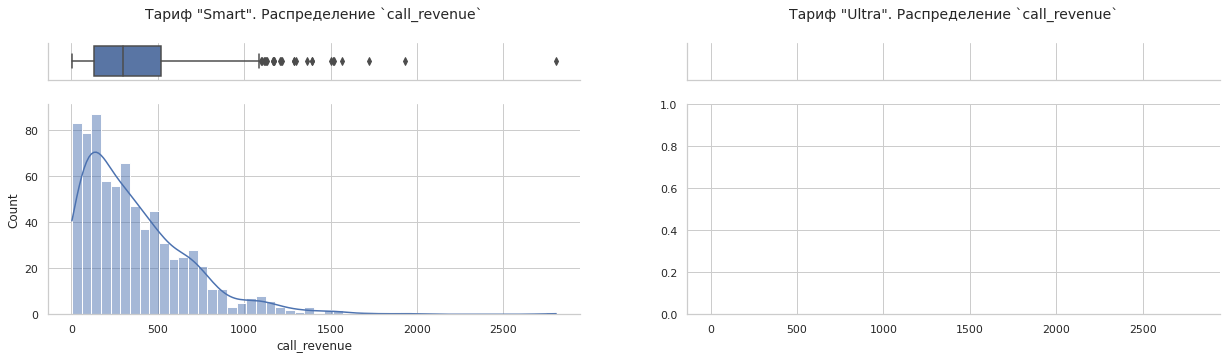



Графики распределения параметра с учетом нулевых значений: 



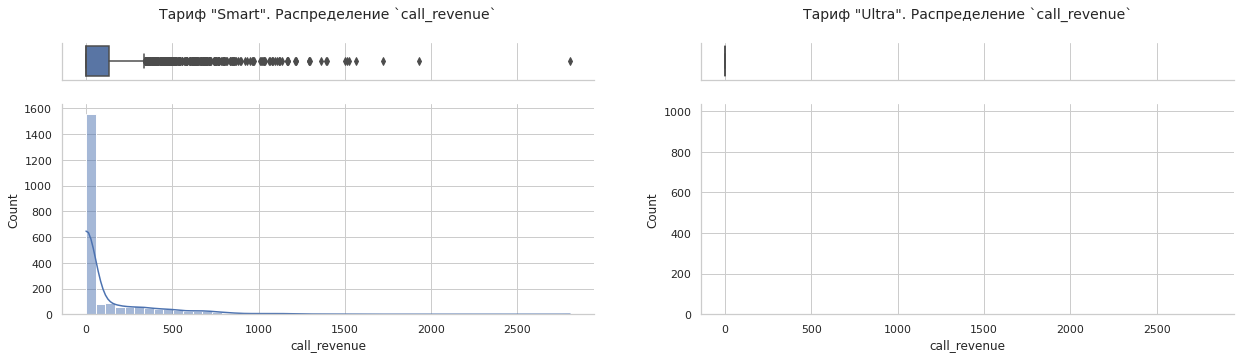



Описательные статистики параметра:

Дисперсия параметра: 48047.5


,STATS,call_revenue_ALL,call_revenue_SMART,call_revenue_ULTRA
0,count,3214.00,2229.00,985.0
1,mean,86.56,124.82,0.0
2,std,219.23,254.04,0.0
3,min,0.00,0.00,0.0
4,25%,0.00,0.00,0.0
5,50%,0.00,0.00,0.0
6,75%,0.00,135.00,0.0
7,max,2805.00,2805.00,0.0


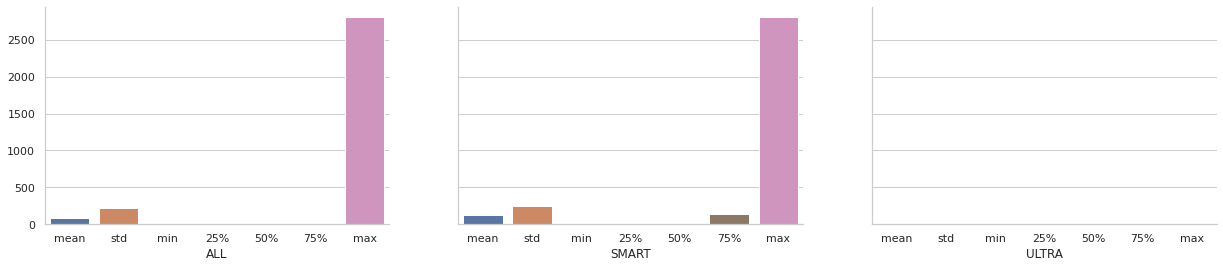




   -----------------------------------------------------------------------------------------------------------------------------------------
2. ----------------------------------------------------- Анализ параметра messages_revenue -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра без учета нулевых значений: 



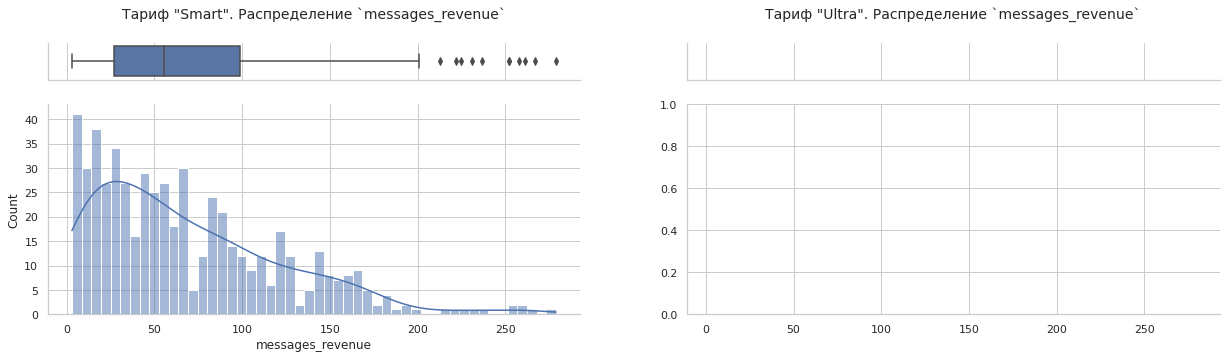



Графики распределения параметра с учетом нулевых значений: 



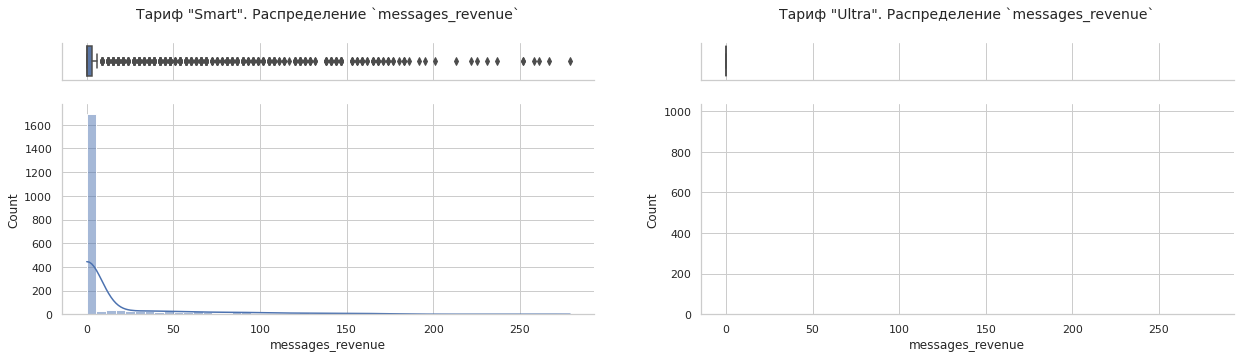



Описательные статистики параметра:

Дисперсия параметра: 1191.73


,STATS,messages_revenue_ALL,messages_revenue_SMART,messages_revenue_ULTRA
0,count,3214.00,2229.00,985.0
1,mean,12.07,17.40,0.0
2,std,34.53,40.33,0.0
3,min,0.00,0.00,0.0
4,25%,0.00,0.00,0.0
5,50%,0.00,0.00,0.0
6,75%,0.00,3.00,0.0
7,max,279.00,279.00,0.0


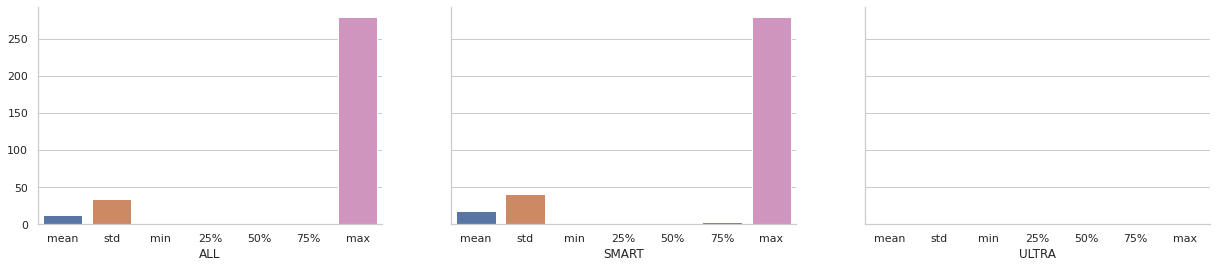




   -----------------------------------------------------------------------------------------------------------------------------------------
3. ----------------------------------------------------- Анализ параметра internet_revenue -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра без учета нулевых значений: 



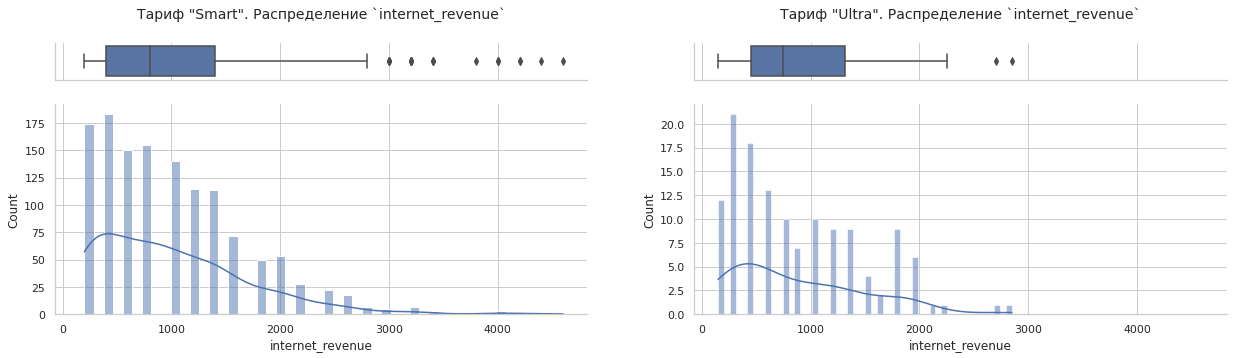



Графики распределения параметра с учетом нулевых значений: 



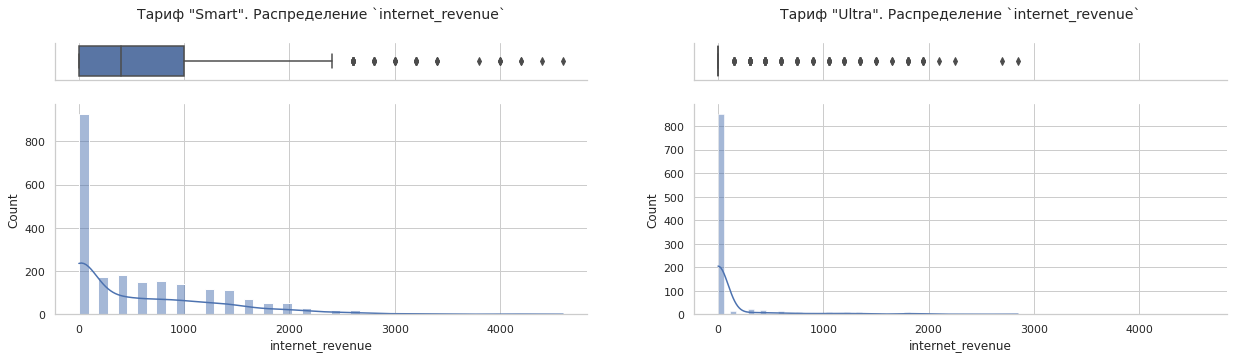



Описательные статистики параметра:

Дисперсия параметра: 467898.67


,STATS,internet_revenue_ALL,internet_revenue_SMART,internet_revenue_ULTRA
0,count,3214.00,2229.00,985.00
1,mean,451.38,597.76,120.15
2,std,684.14,736.56,376.19
3,min,0.00,0.00,0.00
4,25%,0.00,0.00,0.00
5,50%,0.00,400.00,0.00
6,75%,800.00,1000.00,0.00
7,max,4600.00,4600.00,2850.00


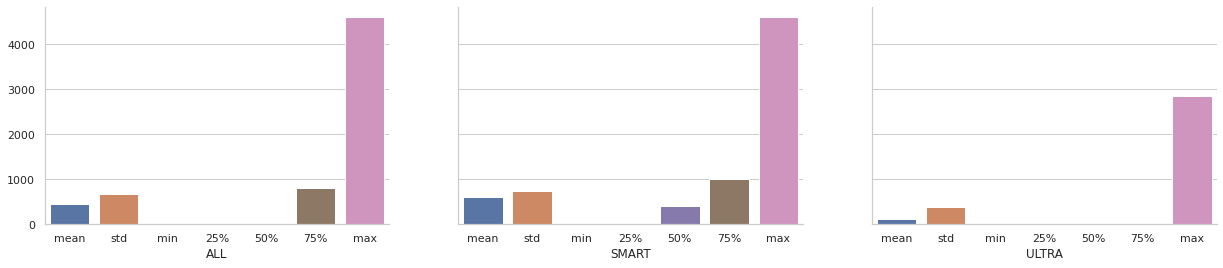




   -----------------------------------------------------------------------------------------------------------------------------------------
4. ----------------------------------------------------- Анализ параметра total_revenue -----------------------------------------------------
   -----------------------------------------------------------------------------------------------------------------------------------------


Графики распределения параметра без учета стоимости тарифа (550 и 1950 р/мес): 



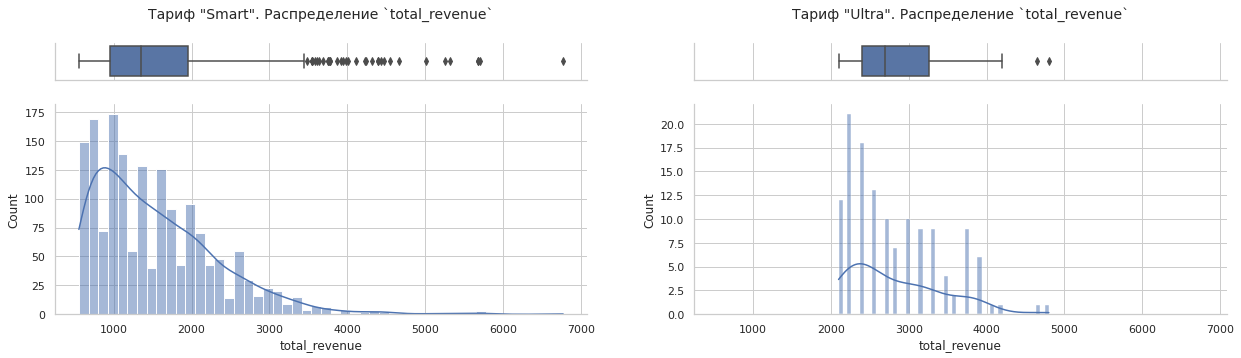



Графики распределения параметра с учетом стоимости тарифа (550 и 1950 р/мес): 



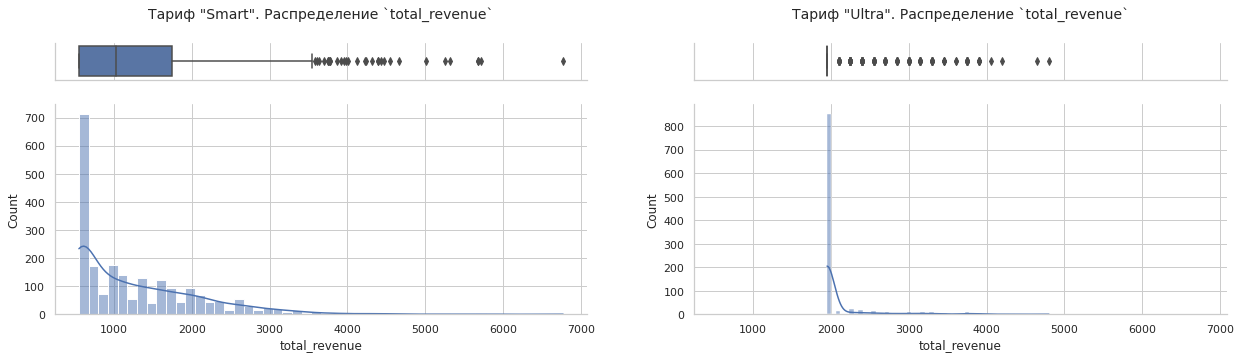



Описательные статистики параметра:

Дисперсия параметра: 637006.55


,STATS,total_revenue_ALL,total_revenue_SMART,total_revenue_ULTRA
0,count,3214.00,2229.00,985.00
1,mean,1529.08,1289.97,2070.15
2,std,798.25,818.40,376.19
3,min,550.00,550.00,1950.00
4,25%,750.00,550.00,1950.00
5,50%,1653.50,1023.00,1950.00
6,75%,1950.00,1750.00,1950.00
7,max,6770.00,6770.00,4800.00


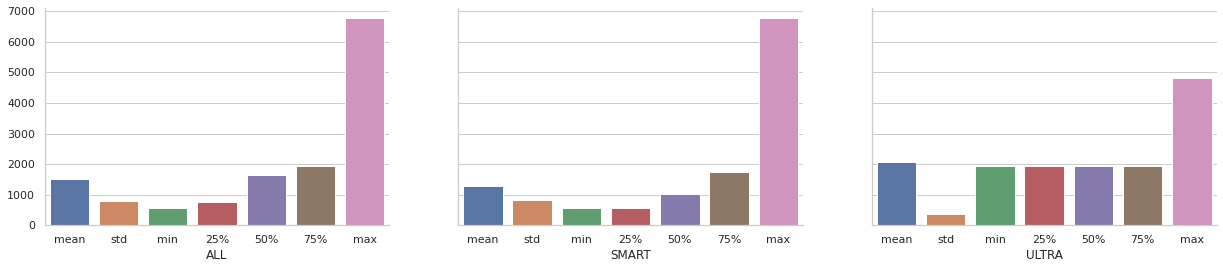

In [29]:
smart_data_rev = data.query('tariff_name == "smart"')[['call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue']]
ultra_data_rev = data.query('tariff_name == "ultra"')[['call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue']]

count = 0

for i in smart_data_rev.columns:
    count += 1
    print(f'{b_start}   -----------------------------------------------------------------------------------------------------------------------------------------')
    print(f'{count}. ----------------------------------------------------- Анализ параметра {i} -----------------------------------------------------')
    print(f'   -----------------------------------------------------------------------------------------------------------------------------------------')
    print('\n')
    
    if i != 'total_revenue':
        print(f'Графики распределения параметра без учета нулевых значений: ')
        print()
        get_hist_plots_2dfs(df1=smart_data_rev.query(f'{i} > 0'), df2=ultra_data_rev.query(f'{i} > 0'), i=i)
        print('\n')
    
        print(f'{b_start}Графики распределения параметра с учетом нулевых значений: ')
        print()
        get_hist_plots_2dfs(df1=smart_data_rev, df2=ultra_data_rev, i=i)
        print('\n')
    else:
        print(f'Графики распределения параметра без учета стоимости тарифа (550 и 1950 р/мес): ')
        print()
        get_hist_plots_2dfs(df1=smart_data_rev.query(f'{i} > 550'), df2=ultra_data_rev.query(f'{i} > 1950'), i=i)
        print('\n')
        
        print(f'{b_start}Графики распределения параметра с учетом стоимости тарифа (550 и 1950 р/мес): ')
        print()
        get_hist_plots_2dfs(df1=smart_data_rev, df2=ultra_data_rev, i=i)
        print('\n')
    
    print(f'{b_start}Описательные статистики параметра:')
    print()
    print('Дисперсия параметра:', round(np.var(data[i]), 2))
    get_stats_table(df1=smart_data_rev, df2=ultra_data_rev, i=i)
    print('\n'*2)

### Медианы и средние для выручки

In [30]:
print(f'{b_start}Медианы для всех параметров:')
create_pivot(df=data, func='median', val=['call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue'])
print('\n')

print(f'{b_start}Cредние для всех параметров:')
create_pivot(df=data, func='mean', val=['call_revenue', 'messages_revenue', 'internet_revenue', 'total_revenue'])

Медианы для всех параметров:


month               1           2           3           4           5         \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_revenue         0     0     0     0     0     0     0     0     0     0   
internet_revenue     0     0     0     0   200     0     0     0   200     0   
messages_revenue     0     0     0     0     0     0     0     0     0     0   
total_revenue      550  1950   550  1950   886  1950   620  1950   986  1950   

month               6           7           8           9           10        \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_revenue         0     0     0     0     0     0     0     0     0     0   
internet_revenue   200     0   200     0   400     0   200     0   400     0   
messages_revenue     0     0     0     0     0     0     0     0     0     0   
total_revenue      950  1950   981  1950  1079  1950   958  1950  1150  1950   

month               11          12        
tariff_name      smart ultra smart ultra  
call_revenue         0     0     0     0  
internet_revenue   400     0   600     0  
messages_revenue     0     0     0     0  
total_revenue     1150  1950  1277  1950



Cредние для всех параметров:


month               1           2           3           4           5         \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_revenue         4     0    44     0   103     0    80     0    82     0   
internet_revenue   164     0   227    25   496    64   321    51   548   109   
messages_revenue     2     0     5     0    15     0    11     0    16     0   
total_revenue      721  1950   827  1975  1164  2014   963  2001  1197  2059   

month               6           7           8           9           10        \
tariff_name      smart ultra smart ultra smart ultra smart ultra smart ultra   
call_revenue        88     0   103     0   122     0   129     0   132     0   
internet_revenue   548    89   553   168   629   133   553    74   663   115   
messages_revenue    17     0    17     0    18     0    17     0    17     0   
total_revenue     1204  2039  1223  2118  1320  2083  1249  2024  1364  2065   

month               11          12        
tariff_name      smart ultra smart ultra  
call_revenue       131     0   203     0  
internet_revenue   643   142   802   188  
messages_revenue    18     0    22     0  
total_revenue     1343  2092  1578  2138

Исходя из анализа распределения выручки можно выделить следующие моменты:
- У Клиентов с тарифом "Ультра" практически не наблюдается плата за превышение тарифов, за исключением использования интернета;
- Медианные и средние выручки выше у тарифа "Ультра" почти в два раза.

## Динамика выручки в 2018 году

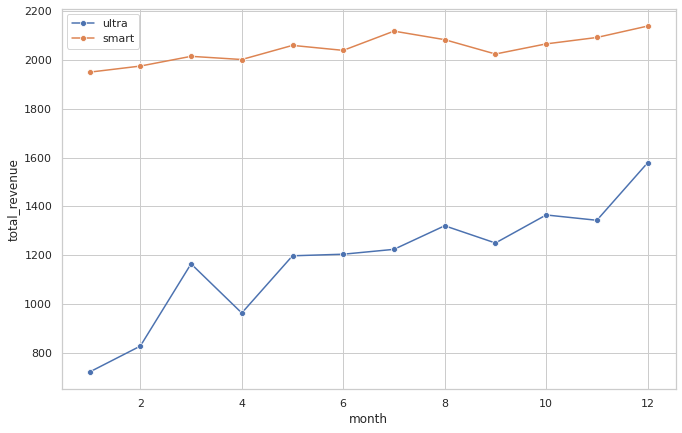

Прирост средней выручки, тариф "Смарт": 219% 
Прирост средней выручки, тариф "Ультра": 110%


In [31]:
smart_data = data.query('tariff_name == "smart"')
ultra_data = data.query('tariff_name == "ultra"')

smart_piv_rev = smart_data.pivot_table(index='month', values='total_revenue', aggfunc='mean')
ultra_piv_rev = ultra_data.pivot_table(index='month', values='total_revenue', aggfunc='mean')


plt.figure(figsize=(11, 7))

sns.lineplot(x=smart_piv_rev.index, y=smart_piv_rev['total_revenue'], marker='o')
sns.lineplot(x=ultra_piv_rev.index, y=ultra_piv_rev['total_revenue'], marker='o')

legend=['ultra', 'smart']
plt.legend(legend)

plt.show()

print(
    'Прирост средней выручки, тариф "Смарт":', f"{round(smart_piv_rev['total_revenue'][12] / smart_piv_rev['total_revenue'][1] * 100)}%",
    '\n'
    'Прирост средней выручки, тариф "Ультра":', f"{round(ultra_piv_rev['total_revenue'][12] / ultra_piv_rev['total_revenue'][1] * 100)}%",
)

Выручка за 2018 год кратно выросла по обоим тарифам:
 - Прирост средней выручки, тариф "Смарт": 219%
 - Прирост средней выручки, тариф "Ультра": 110%

## Корреляции параметров

<AxesSubplot:>

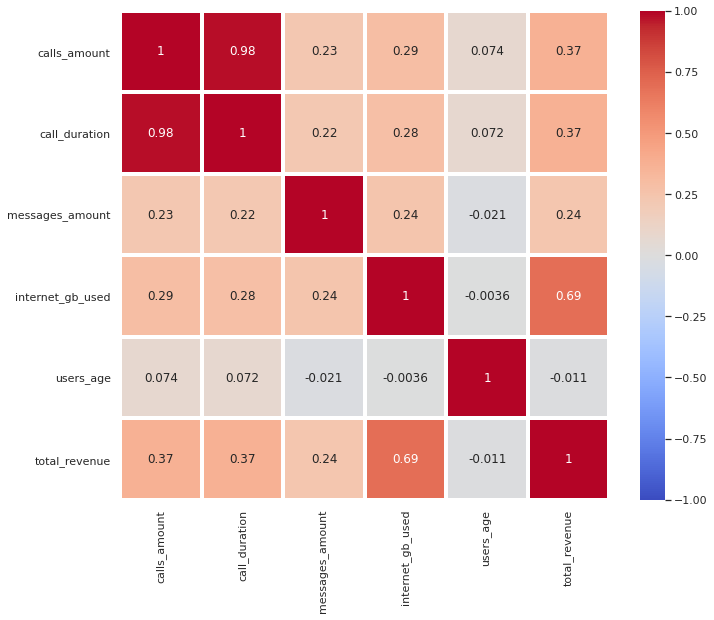

In [32]:
plt.figure(figsize=(11, 9))

sns.heatmap(
    data[
        ['calls_amount', 'call_duration', 'messages_amount', 'internet_gb_used', 'users_age', 'total_revenue']
    ].dropna().corr(), vmax=1, vmin=-1, square=True, linewidths=3, annot=True, cmap='coolwarm'
)

Анализ корреляции позволяет сделать следующий вывод: 
- На общую выручку оказывает заметное прямое влияние только количество использованных гигабайтов;
- Возраст Клиента не оказывает никакого влияния ни на один из параметров.

# Проверка гипотез

## Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Для проверки данной гипотезы сформулируем нулевую гипотезы `H0` и `H1`.

Пусть `H0` звучит следующим образом: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются". Тогда мы сможем проверить её с помощью статистики разности.

Тогда `H1` можно сформулировать так: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

Критический уровень статистической `alpha` значимости возьмем за общепринятый 0,5%

In [33]:
alpha = .05

results = st.ttest_ind(
    smart_data_rev['total_revenue'], 
    ultra_data_rev['total_revenue'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Принимаем H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются")
else:
    print("Принимаем H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются")

p-значение: 1.4229814360764067e-160
Принимаем H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


- Наиболее вероятно, что выручка у двух тарифов различается.

<AxesSubplot:xlabel='tariff_name', ylabel='total_revenue'>

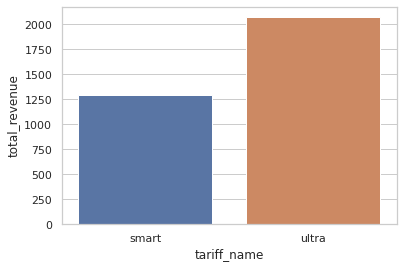

In [34]:
data.pivot_table(index='tariff_name', values='total_revenue', aggfunc='mean')

sns.barplot(
    x=data.pivot_table(index='tariff_name', values='total_revenue', aggfunc='mean').index,
    y=data.pivot_table(index='tariff_name', values='total_revenue', aggfunc='mean')['total_revenue']
)

## Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Аналогично поступим для проверки гипотезы о различии средней выручки в Москве и в регионах.

Сформулируем H0: "Средняя выручка пользователей из Москвы не отличается от выручки из других регионов"

Критический уровень статистической `alpha` значимости возьмем за общепринятый 0,5%

In [35]:
alpha = .05

results = st.ttest_ind(
    data.query('users_city == "Москва"')['total_revenue'], 
    data.query('users_city != "Москва"')['total_revenue'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу - средняя выручка пользователей из Москвы отличается от выручки из других регионов")
else:
    print("Принимаем нулевую гипотезу - средняя выручка пользователей из Москвы не отличается от выручки из других регионов")

p-значение: 0.5440152911670224
Принимаем нулевую гипотезу - средняя выручка пользователей из Москвы не отличается от выручки из других регионов


- Наиболее вероятно, что средняя выручка пользователей из Москвы не отличается от выручки из других регионов.

# Вывод

В рамках данного исследования была проанализрована выборка из 500 клиентов компании "Мегалайн".

Было решено объединить датафреймы с данными таким образом, чтобы прослеживалась информация о тарифе каждого клиента.
Для этого была объединина таблицу с информацией о клиентах `users` с информацией о тарифах `tariffs` по полю `tariff_name`, а после полученная таблица была совмещена с данными об использовании возможностей тарифов.

Для исследования был сформирован датасет `data`, содержащий в себе сведенную информацию по каждому Клиенту из выборки о его ежемесячной активности за 2018 год, а также о выручке, которую он принес Компании за каждый месяц.

При анализе датасета были получены следующие результаты:

**1. Результаты анализа Клиентов по гендерному признаку:**
- Клиентов-женщин меньше почти в 10 раз, что может говорить о недостаточной проработке данного сегмента рынка;
- Клиенты-женщины на 8% чаще выбирают тариф "Ультра", однако стоит учитывать относительно небольшую выборку всего в 349 человек.
- Гендер не влияет на общую выручку: у Клиентов-мужчин и женщин она практически одинакова;
- Гендер влияет на выручку от звонков, интернета и SMS - Клиенты-мужчины тратят на эти категории значительно больше.
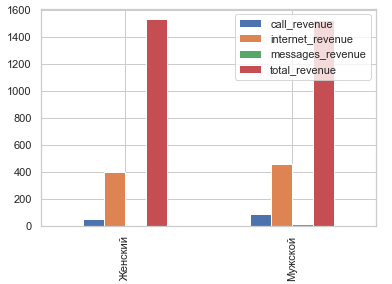
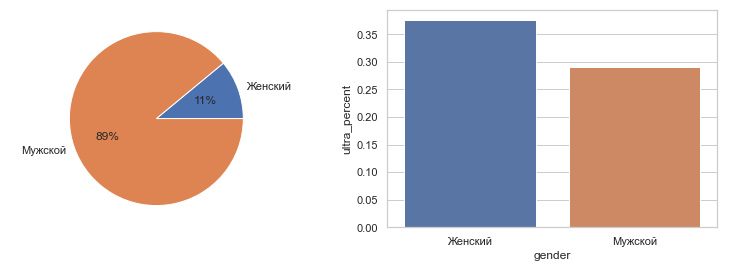

**2. Результаты анализа Клиентов по доли клиентов в различных городах:**

- Доля тарифов сильно не равномерна в разных регионах;
- Присутствуют регионы, в которых представлен только один тариф.
- показатели неравномерно распределяется по городам;
- Медианная выручка сильно искажается из-за непревышения Клиентами лимитов тарифа, в следствие чего, целесообразнее использовать показатель средней выручки при дальнейшем анализе.
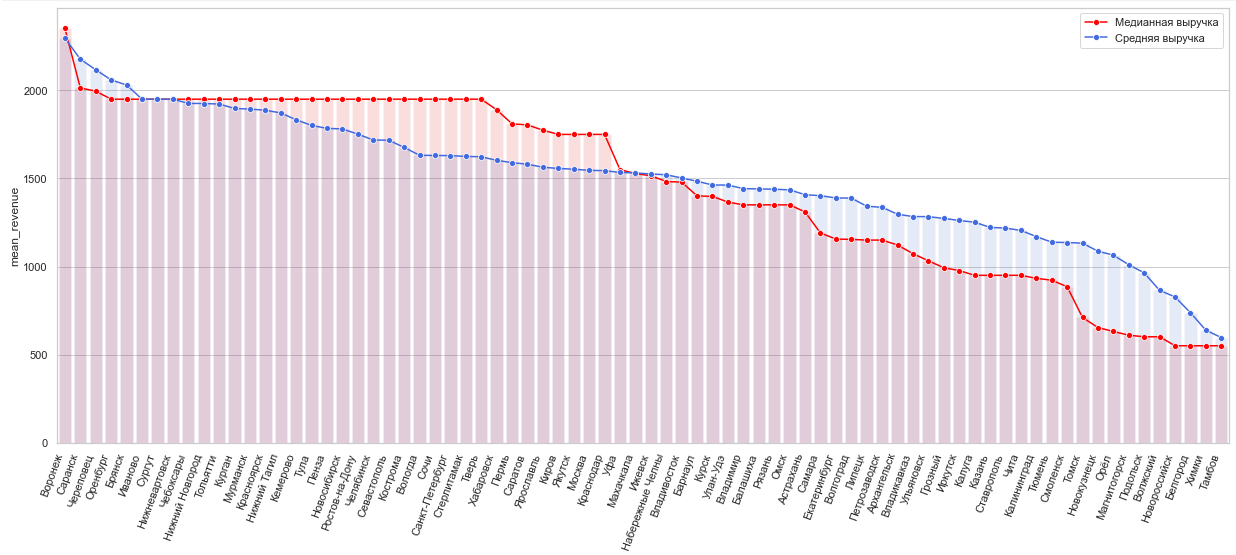
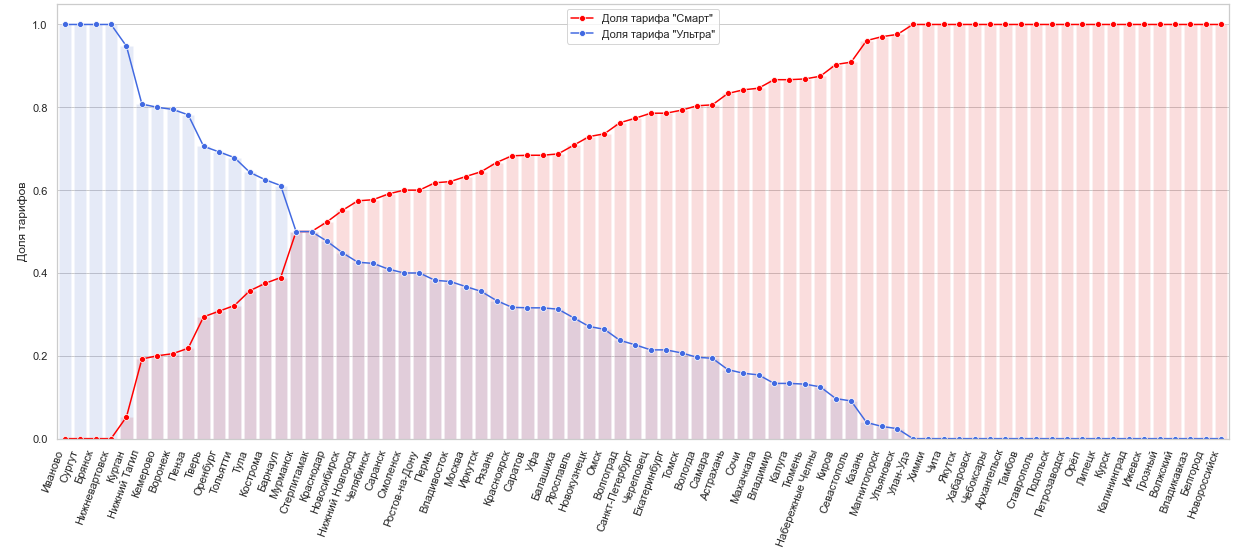

**3. Рузультаты анализа выручки для тарифов**

- У Клиентов с тарифом "Ультра" практически не наблюдается плата за превышение тарифов, за исключением использования интернета;
- Медианные и средние выручки выше у тарифа "Ультра" почти в два раза.
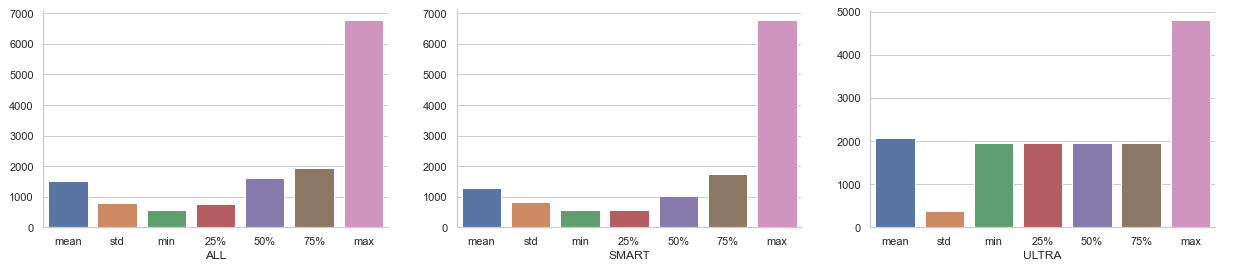
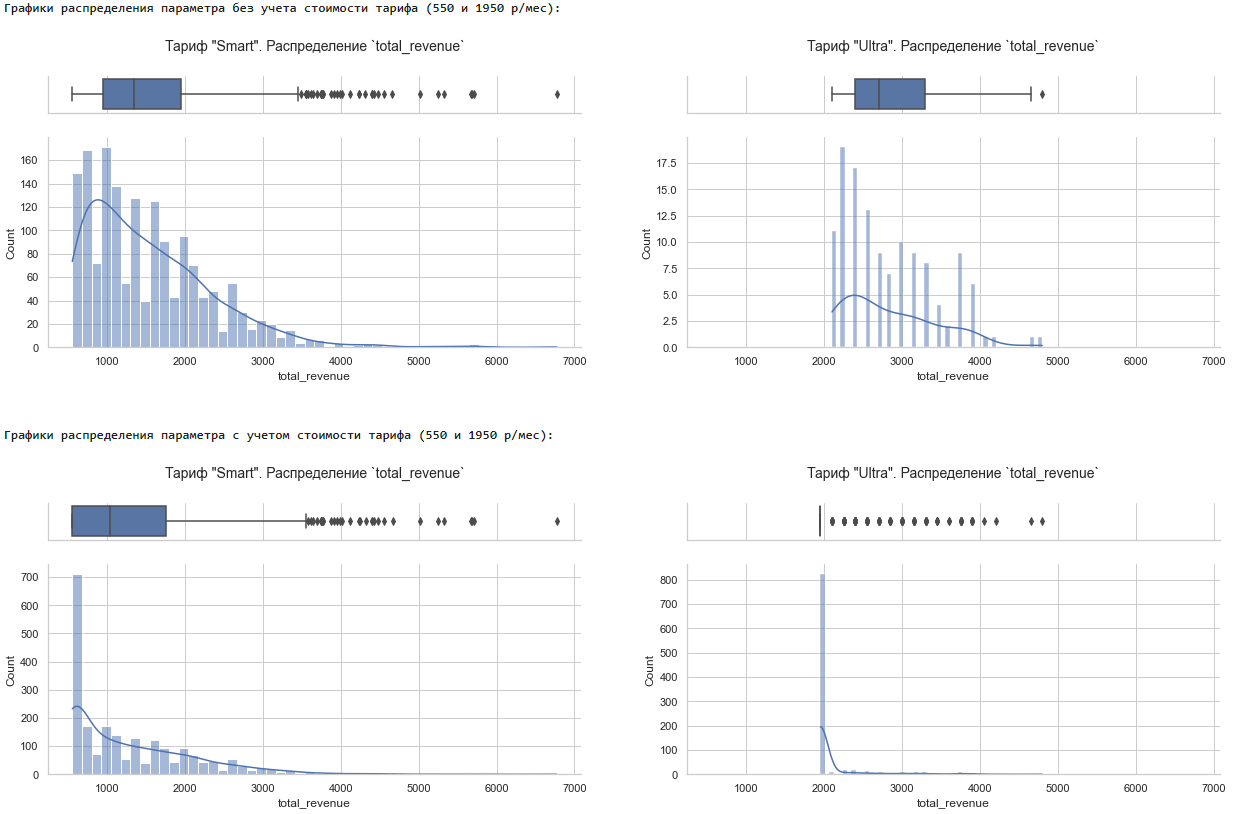

**4. Динамика выручки в 2018 году**

Выручка за 2018 год кратно выросла по обоим тарифам:
- Прирост средней выручки, тариф "Смарт": 219%;
- Прирост средней выручки, тариф "Ультра": 110%.
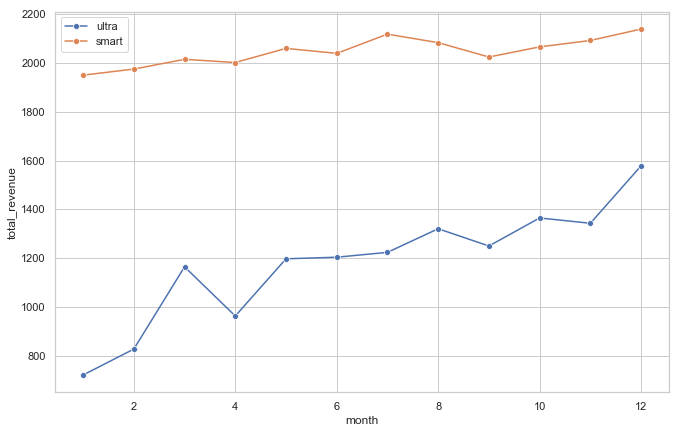

**4. Результаты анализа корреляции параметров**

- На общую выручку оказывает заметное прямое влияние только количество использованных гигабайтов;
- Возраст Клиента не оказывает никакого влияния ни на один из параметров.
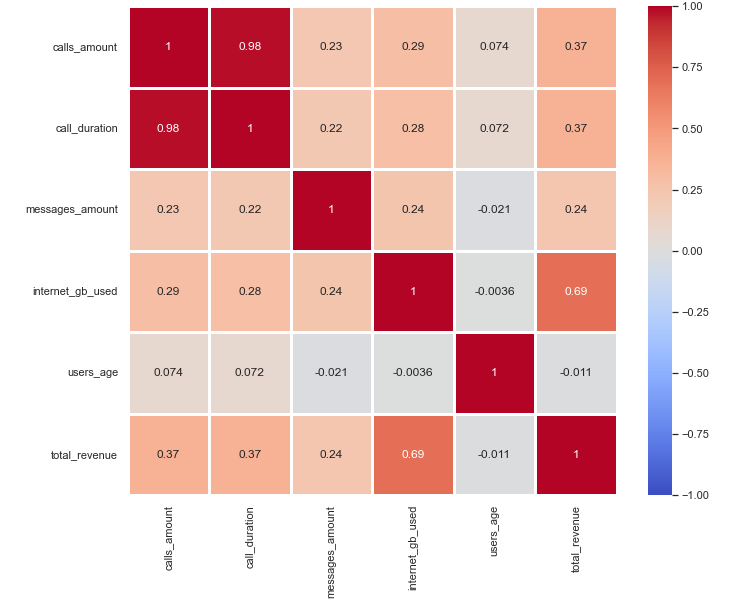

**Также в рамках данного исследования были проверены статистические гипотезы.**

С высокой вероятностью можно утверждать, что:

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Cредняя выручка пользователей из Москвы не отличается от выручки из других регионов

**Таким образом, можно сказать, что наиболее выгодным тарифом для компании "Мегалайн" является тариф "Ультра"**